## **📦 Install and Import Dependencies**

Before we begin, we need to install and import all the required libraries.  

- **Albumentations** → for powerful image augmentation.  
- **OpenCV (cv2)** → for image processing.  
- **PyTorch** → for deep learning model building and training.  
- **NumPy, Matplotlib** → for numerical computations and visualizations.  
- **tqdm** → for progress bars during training.  


In [ ]:

!pip -q install albumentations==1.4.4 opencv-python==4.10.0.84

import os, glob, random, math
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 13.4 MB/s eta 0:00:00


## **📂 Dataset Setup and Configuration**

First, we define the dataset structure and basic training configurations.

- **Dataset Path** → The dataset is stored in Google Drive under `Chest-X-Ray`.  
  - `images/` → contains chest X-ray images  
  - `masks/` → contains corresponding segmentation masks  

- **Training Configurations**  
  - `IMG_SIZE` → input image size (256×256)  
  - `BATCH_SIZE` → number of samples per batch  
  - `LR` → learning rate  
  - `EPOCHS` → number of training iterations  
  - `VAL_SPLIT` & `TEST_SPLIT` → percentage of data used for validation and testing  

- **Normalization** → since images are grayscale, we use mean and standard deviation of `0.5`.  

- **Device Setup** → automatically selects GPU (`cuda`) if available, otherwise CPU.  

- **Reproducibility** → a `set_seed` function is defined to ensure consistent results.  

Finally, we verify that both `images/` and `masks/` directories exist and print the selected device.  


In [ ]:

# Expected structure:
# x-ray/
#   ├── images/
#   └── masks/
DATA_DIR = "/content/drive/MyDrive/Chest-X-Ray"

IMG_DIR = os.path.join(DATA_DIR, "image")
MASK_DIR = os.path.join(DATA_DIR, "mask")

# Image size & training config
IMG_SIZE   = 256
BATCH_SIZE = 8
LR         = 1e-3
EPOCHS     = 100
VAL_SPLIT  = 0.15
TEST_SPLIT = 0.15

# Normalization for 1-channel (grayscale)
MEAN = (0.5,)
STD  = (0.5,)

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

assert os.path.isdir(IMG_DIR),  f"Images folder not found at: {IMG_DIR}"
assert os.path.isdir(MASK_DIR), f"Masks folder not found at: {MASK_DIR}"
print(f"Using device: {DEVICE}")


Using device: cuda


## **🔗 Pairing Images with Masks & Dataset Splitting**

Now we create a function `get_pairs` that matches each **image** with its corresponding **mask** using filenames.  

- **Process**:  
  1. Collect all image and mask file paths.  
  2. Match images and masks by filename (without extension).  
  3. Report total images, total masks, matched pairs, and warn if some images are missing masks.  

After pairing:  
- The dataset is **shuffled** to ensure randomness.  
- The data is split into:  
  - **Training set** → largest portion for model learning  
  - **Validation set** → for tuning and preventing overfitting  
  - **Test set** → for final unbiased evaluation  

Finally, the script prints out the counts for each split.  


In [ ]:
def get_pairs(img_dir, mask_dir):
    img_paths  = sorted([p for p in glob.glob(os.path.join(img_dir, "*")) if os.path.isfile(p)])
    mask_paths = sorted([p for p in glob.glob(os.path.join(mask_dir, "*")) if os.path.isfile(p)])

    mask_map = {Path(p).stem: p for p in mask_paths}
    pairs, missing = [], []

    for ip in img_paths:
        key = Path(ip).stem
        mp = mask_map.get(key, None)
        if mp is not None:
            pairs.append((ip, mp))
        else:
            missing.append(ip)

    print(f"Total images found: {len(img_paths)}")
    print(f"Total masks  found: {len(mask_paths)}")
    print(f"Matched pairs:      {len(pairs)}")
    if missing:
        print(f"WARNING: Missing masks for {len(missing)} images (showing first 5):")
        print("\n".join(missing[:5]))
    return pairs

pairs = get_pairs(IMG_DIR, MASK_DIR)
random.shuffle(pairs)

n_total = len(pairs)
n_test  = int(n_total * TEST_SPLIT)
n_val   = int(n_total * VAL_SPLIT)
n_train = n_total - n_val - n_test

train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

print(f"\nSplit counts -> Total: {n_total} | Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}")


Total images found: 704
Total masks  found: 704
Matched pairs:      704

Split counts -> Total: 704 | Train: 494 | Val: 105 | Test: 105


## **🗂️ Custom Dataset Class for Segmentation**

We define a PyTorch `Dataset` class called **`SegDataset`** to handle image–mask pairs.

### 🔑 Key Steps:
1. **Initialization (`__init__`)**  
   - Takes in a list of `(image_path, mask_path)` pairs.  
   - Optionally applies transformations (Albumentations).  

2. **Length (`__len__`)**  
   - Returns the total number of samples.  

3. **Get Item (`__getitem__`)**  
   - Loads an image (grayscale) and its mask.  
   - Ensures both files are successfully read.  
   - Converts the mask into binary form `{0,1}`.  
   - Expands both image and mask to **HxWx1** format before transformations.  

4. **Transformations**  
   - If Albumentations transforms are provided, both image and mask are augmented together.  
   - Ensures the mask has shape `[1, H, W]` and values `{0,1}`.  
   - If no transform is provided, the image and mask are simply normalized and converted into tensors.  

✅ Final output:  
- `img` → `torch.FloatTensor` with shape `[1, H, W]`  
- `msk` → binary `torch.FloatTensor` with shape `[1, H, W]`  


In [ ]:
class SegDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        msk  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")
        if msk is None:
            raise FileNotFoundError(f"Could not read mask: {mask_path}")

        # Binarize mask to {0,1}
        msk = (msk > 127).astype(np.float32)

        # Expand channel dim to HxWx1 before albumentations
        img = np.expand_dims(img, axis=-1)  # uint8
        msk = np.expand_dims(msk, axis=-1)  # float32 {0,1}

        if self.transform:
            augmented = self.transform(image=img, mask=msk)
            img = augmented["image"]          # torch.FloatTensor [1,H,W]
            msk = augmented["mask"]           # torch.FloatTensor [1,H,W] (because transpose_mask=True)

            # Safety: force mask to [1,H,W] float in {0,1}
            if msk.ndim == 2:                 # [H,W]
                msk = msk.unsqueeze(0)
            elif msk.ndim == 3 and msk.shape[0] != 1:  # e.g., [H,W,1] came through somehow
                msk = msk.permute(2, 0, 1)
            msk = (msk > 0.5).float()
        else:
            img = torch.from_numpy(img.transpose(2,0,1)).float() / 255.0
            msk = torch.from_numpy(msk.transpose(2,0,1)).float()

        return img, msk


## 🎨 **Data Augmentation, Dataloaders & Visualization**

To improve generalization and robustness, we apply **Albumentations pipelines** for data preprocessing and augmentation.  

### 🔧 Transformations
- **Training Pipeline**
  - Resize to `IMG_SIZE × IMG_SIZE`
  - Random horizontal & vertical flips
  - Small shifts, scaling, and rotations
  - Random brightness/contrast adjustments
  - Gaussian blur
  - Normalize grayscale images using `(mean=0.5, std=0.5)`
  - Convert to PyTorch tensors with `ToTensorV2`

- **Validation/Test Pipeline**
  - Only resizing + normalization (no heavy augmentations)

### 📂 Dataset & Dataloaders
- `SegDataset` is wrapped into:
  - **Training set** with augmentations
  - **Validation & Test sets** with simple preprocessing
- `DataLoader` objects are created for batching and efficient GPU training.

### 👀 Visualization Helpers
- **`denorm_img`** → reverses normalization for visualization.  
- **`show_samples`** → displays:
  1. The input X-ray image  
  2. Its corresponding binary mask  
  3. An overlay of mask on the image  

Finally, we visualize a few training samples to confirm augmentation and preprocessing are working correctly.  


Final counts -> Train: 494 | Val: 105 | Test: 105


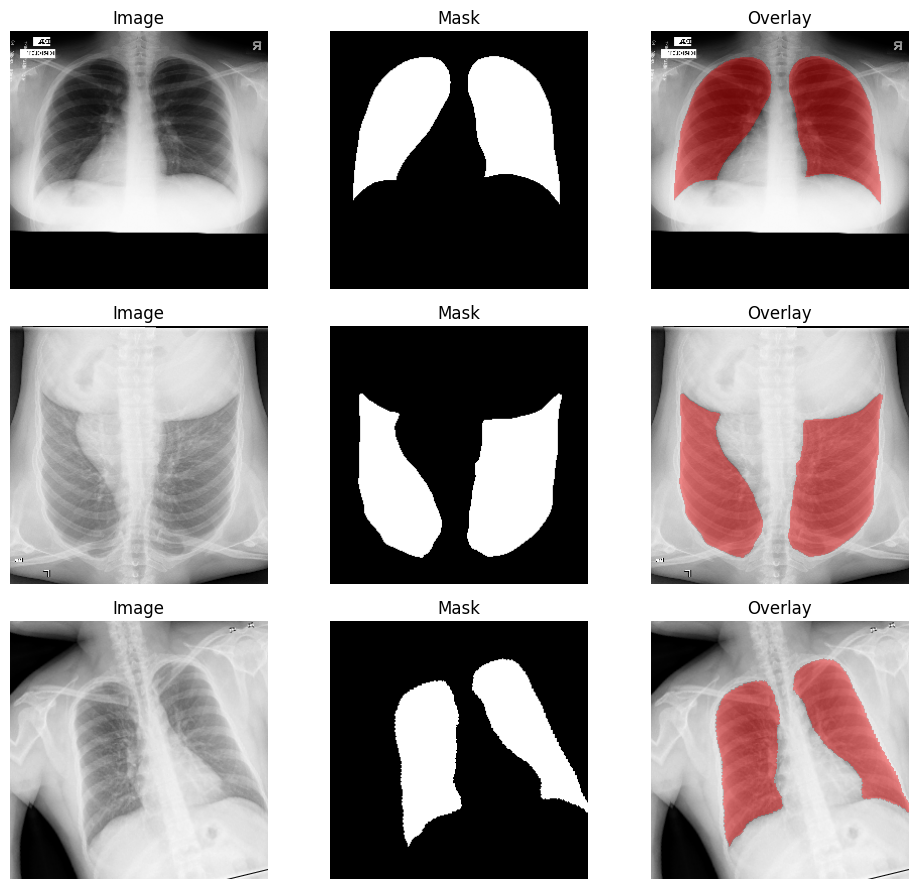

In [ ]:
# Albumentations pipelines
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True),  # 👈 important
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True),  # 👈 important
])

train_ds = SegDataset(train_pairs, transform=train_tfms)
val_ds   = SegDataset(val_pairs,   transform=val_tfms)
test_ds  = SegDataset(test_pairs,  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Final counts -> Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# ---------- Quick visualization helpers ----------
def denorm_img(t):
    """Undo Normalize(mean=0.5, std=0.5) for grayscale to get back to [0,1] for display."""
    # t: torch tensor [1,H,W]
    out = t.clone()
    out = out * STD[0] + MEAN[0]
    return torch.clamp(out, 0, 1)

def show_samples(ds, n=3):
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        img_t, mask_t = ds[idx]  # tensors
        img = denorm_img(img_t[0]).cpu().numpy()   # HxW in [0,1]
        msk = mask_t[0].cpu().numpy()              # HxW in {0,1}

        axes[row, 0].imshow(img, cmap="gray")
        axes[row, 0].set_title("Image")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(msk, cmap="gray")
        axes[row, 1].set_title("Mask")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(img, cmap="gray")
        axes[row, 2].imshow(np.ma.masked_where(msk == 0, msk), alpha=0.4, cmap="autumn")
        axes[row, 2].set_title("Overlay")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize a few train samples (after aug/normalize)
show_samples(train_ds, n=3)


## **✅ Sanity Check: DataLoader Shapes**

Before moving forward, we verify that our `DataLoader` is producing batches in the correct format.

- `xb` → batch of input X-ray images  
- `yb` → batch of corresponding masks  

Expected shape:  
- **Images** → `[B, 1, H, W]`  
- **Masks** → `[B, 1, H, W]`  

Where:  
- `B` = batch size  
- `1` = single grayscale channel  
- `H, W` = resized image dimensions (256 × 256 in our case)  

This quick check ensures the dataset and augmentations are correctly set up before training.  


In [ ]:
# Sanity check shapes from the loaders
xb, yb = next(iter(train_loader))
print("Train batch shapes:", xb.shape, yb.shape)  # expect: [B,1,H,W] [B,1,H,W]


Train batch shapes: torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


## **🏗️ Building the U-Net Architecture**

We now implement the **U-Net** architecture, a popular encoder–decoder network for image segmentation.

### 🔑 Components

1. **DoubleConv**
   - Two consecutive `Conv2d → BatchNorm → ReLU` layers.
   - Helps extract features while preserving spatial details.

2. **Down (Encoder block)**
   - `MaxPool2d` to reduce spatial dimensions by half.  
   - Followed by `DoubleConv` for deeper feature extraction.  

3. **Up (Decoder block)**
   - `ConvTranspose2d` for upsampling (doubling spatial dimensions).  
   - Padding applied if dimensions don’t match.  
   - Skip connections: concatenates encoder features (`x2`) with upsampled features (`x1`).  
   - Followed by `DoubleConv`.  

4. **UNet**
   - Encoder path: progressively downsamples (`inc`, `down1`, `down2`, `down3`).  
   - Bottleneck: `DoubleConv` with the deepest features.  
   - Decoder path: progressively upsamples while fusing encoder features (`up1`, `up2`, `up3`, `up4`).  
   - Final layer: `1×1 Conv2d` reduces channels to `out_ch` (segmentation mask).  

### ⚙️ Flow
- Input → Encoder (downsampling) → Bottleneck → Decoder (upsampling + skip connections) → Output mask.  

✅ Output: predicted segmentation map with shape `[B, out_ch, H, W]`.  


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)  # upsample
        # Pad if necessary (in case of size mismatch due to odd dims)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        # Concatenate along channels
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, features=(64, 128, 256, 512)):
        super().__init__()
        f1, f2, f3, f4 = features

        self.inc = DoubleConv(in_ch, f1)
        self.down1 = Down(f1, f2)
        self.down2 = Down(f2, f3)
        self.down3 = Down(f3, f4)
        self.bottom = DoubleConv(f4, f4 * 2)

        self.up1 = Up(f4 * 2, f4)
        self.up2 = Up(f4, f3)
        self.up3 = Up(f3, f2)
        self.up4 = Up(f2, f1)

        self.outc = nn.Conv2d(f1, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)       # 64
        x2 = self.down1(x1)    # 128
        x3 = self.down2(x2)    # 256
        x4 = self.down3(x3)    # 512
        xb = self.bottom(x4)   # 1024

        x = self.up1(xb, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)
        return logits


## **⚖️ Metrics, Loss Functions & Training Pipeline**

To effectively train and evaluate our U-Net, we define custom **metrics**, **loss functions**, and the training/evaluation loops.

---

### 📊 Metrics
1. **Dice Coefficient (`dice_coef`)**  
   - Measures overlap between predicted mask and ground truth.  
   - Especially useful for imbalanced segmentation tasks.  

2. **Intersection over Union (`iou_score`)**  
   - Ratio of intersection to union between prediction and ground truth.  

3. **Pixel Accuracy (`pixel_accuracy`)**  
   - Fraction of correctly classified pixels across the whole image.  

---

### 🧮 Loss Functions
- **Weighted BCE Loss**  
  - `BCEWithLogitsLoss` with a **positive class weight** to handle imbalance.  
- **Dice Loss**  
  - Encourages overlap between predicted and ground-truth masks.  
- **Combined Loss**  
  - Weighted blend of **BCE** and **Dice** loss (`alpha=0.3` by default).  

---

### 🚀 Training & Evaluation Loops
- **`train_one_epoch`**
  - Runs forward + backward pass on each batch.  
  - Optimizer updates model parameters.  
  - Logs per-batch metrics with `tqdm` progress bar.  

- **`eval_model`**
  - Runs evaluation without gradient updates.  
  - Reports average metrics across validation/test sets.  

---

### ⚙️ Model & Optimizer
- **Model** → U-Net (`in_ch=1`, `out_ch=1`)  
- **Optimizer** → `AdamW` with learning rate `LR` and small weight decay.  

✅ At this stage, the model is fully defined and ready for the training loop.  


In [ ]:
# ----- Metrics -----
def dice_coef(preds, targets, eps: float = 1e-7):
    """
    preds: logits [N,1,H,W] or probabilities; we'll sigmoid inside.
    targets: {0,1} float tensor [N,1,H,W]
    """
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()

    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean()

def iou_score(preds, targets, eps: float = 1e-7):
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()

    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

def pixel_accuracy(preds, targets):
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()
    correct = (preds_bin == targets).float().mean()
    return correct

# ----- Losses -----
pos_weight = torch.tensor([3.0], device=DEVICE)  # tune 2.0–5.0 based on imbalance
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
    def forward(self, preds, targets):
        probs = torch.sigmoid(preds)
        num = 2 * (probs * targets).sum(dim=(1,2,3)) + self.eps
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
        dice = num / den
        return 1 - dice.mean()

dice_loss_fn = DiceLoss()

def combined_loss(preds, targets, alpha=0.3):
    # alpha controls blend between BCE and Dice loss
    return alpha * bce_loss(preds, targets) + (1 - alpha) * dice_loss_fn(preds, targets)

# ----- Train / Eval -----
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss, epoch_dice, epoch_iou, epoch_acc = 0.0, 0.0, 0.0, 0.0

    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, masks in pbar:
        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks, alpha=0.5)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            d = dice_coef(logits, masks).item()
            i = iou_score(logits, masks).item()
            a = pixel_accuracy(logits, masks).item()

        epoch_loss += loss.item()
        epoch_dice += d
        epoch_iou  += i
        epoch_acc  += a

        pbar.set_postfix(loss=loss.item(), dice=d, iou=i, acc=a)

    n = len(loader)
    return (epoch_loss / n, epoch_dice / n, epoch_iou / n, epoch_acc / n)

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    epoch_loss, epoch_dice, epoch_iou, epoch_acc = 0.0, 0.0, 0.0, 0.0

    for imgs, masks in loader:
        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        logits = model(imgs)
        loss = combined_loss(logits, masks, alpha=0.5)

        d = dice_coef(logits, masks).item()
        i = iou_score(logits, masks).item()
        a = pixel_accuracy(logits, masks).item()

        epoch_loss += loss.item()
        epoch_dice += d
        epoch_iou  += i
        epoch_acc  += a

    n = len(loader)
    return (epoch_loss / n, epoch_dice / n, epoch_iou / n, epoch_acc / n)

# ----- Instantiate model / optimizer -----
model = UNet(in_ch=1, out_ch=1).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

## **🏃‍♂️ Training Loop & Checkpointing**

Now we train the U-Net model across multiple epochs.

### 🔑 Workflow
1. **For each epoch:**
   - Run `train_one_epoch` on the training set.  
   - Run `eval_model` on the validation set.  
   - Record loss and Dice score for both train/validation.  

2. **Progress Logging**
   - After every epoch, we print:  
     - Training loss, Dice, IoU, Accuracy  
     - Validation loss, Dice, IoU, Accuracy  

3. **Model Checkpointing**
   - The model is saved as **`best_unet.pth`** whenever validation Dice improves.  
   - Ensures we always keep the best-performing model.  

4. **History Tracking**
   - Training/validation losses and Dice scores are stored in `history` for visualization later.  

✅ At the end of this loop, we’ll have a trained U-Net with the **best checkpoint saved by validation Dice**.  


In [ ]:


# ----- Training loop -----
best_val_dice = -1.0
history = {"train_loss": [], "train_dice": [], "val_loss": [], "val_dice": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_dice, tr_iou, tr_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_dice, val_iou, val_acc = eval_model(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_dice"].append(tr_dice)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss={tr_loss:.4f}, dice={tr_dice:.4f}, iou={tr_iou:.4f}, acc={tr_acc:.4f} | "
          f"Val:   loss={val_loss:.4f}, dice={val_dice:.4f}, iou={val_iou:.4f}, acc={val_acc:.4f}")

    # Save best checkpoint based on validation Dice
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_unet.pth")
        print("  ✅ Saved new best model (by Val Dice) -> best_unet.pth")



Epoch 01/100 | Train: loss=0.4420, dice=0.7529, iou=0.6234, acc=0.8495 | Val:   loss=0.4154, dice=0.7743, iou=0.6376, acc=0.8696
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 02/100 | Train: loss=0.2462, dice=0.8690, iou=0.7758, acc=0.9313 | Val:   loss=0.2000, dice=0.9016, iou=0.8238, acc=0.9474
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 03/100 | Train: loss=0.1924, dice=0.8948, iou=0.8142, acc=0.9464 | Val:   loss=0.1469, dice=0.9090, iou=0.8358, acc=0.9493
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 04/100 | Train: loss=0.1527, dice=0.9186, iou=0.8534, acc=0.9593 | Val:   loss=0.1486, dice=0.9077, iou=0.8334, acc=0.9488


Epoch 05/100 | Train: loss=0.1540, dice=0.9150, iou=0.8467, acc=0.9577 | Val:   loss=0.1563, dice=0.9005, iou=0.8211, acc=0.9442


Epoch 06/100 | Train: loss=0.1262, dice=0.9307, iou=0.8728, acc=0.9658 | Val:   loss=0.1100, dice=0.9473, iou=0.9016, acc=0.9726
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 07/100 | Train: loss=0.1190, dice=0.9352, iou=0.8802, acc=0.9678 | Val:   loss=0.0961, dice=0.9501, iou=0.9065, acc=0.9737
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 08/100 | Train: loss=0.1133, dice=0.9395, iou=0.8878, acc=0.9702 | Val:   loss=0.0916, dice=0.9535, iou=0.9125, acc=0.9755
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 09/100 | Train: loss=0.0988, dice=0.9472, iou=0.9011, acc=0.9740 | Val:   loss=0.0909, dice=0.9531, iou=0.9117, acc=0.9753


Epoch 10/100 | Train: loss=0.1096, dice=0.9406, iou=0.8895, acc=0.9705 | Val:   loss=0.1032, dice=0.9507, iou=0.9075, acc=0.9744


Epoch 11/100 | Train: loss=0.1039, dice=0.9442, iou=0.8959, acc=0.9728 | Val:   loss=0.0872, dice=0.9554, iou=0.9159, acc=0.9766
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 12/100 | Train: loss=0.1008, dice=0.9461, iou=0.8994, acc=0.9737 | Val:   loss=0.0921, dice=0.9512, iou=0.9081, acc=0.9742


Epoch 13/100 | Train: loss=0.0964, dice=0.9481, iou=0.9026, acc=0.9745 | Val:   loss=0.0932, dice=0.9568, iou=0.9185, acc=0.9775
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 14/100 | Train: loss=0.0991, dice=0.9469, iou=0.9006, acc=0.9737 | Val:   loss=0.0963, dice=0.9551, iou=0.9152, acc=0.9763


Epoch 15/100 | Train: loss=0.0952, dice=0.9498, iou=0.9057, acc=0.9754 | Val:   loss=0.0846, dice=0.9569, iou=0.9188, acc=0.9773
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 16/100 | Train: loss=0.1055, dice=0.9436, iou=0.8950, acc=0.9722 | Val:   loss=0.0894, dice=0.9541, iou=0.9135, acc=0.9759


Epoch 17/100 | Train: loss=0.1009, dice=0.9467, iou=0.9001, acc=0.9738 | Val:   loss=0.0886, dice=0.9551, iou=0.9152, acc=0.9763


Epoch 18/100 | Train: loss=0.0963, dice=0.9487, iou=0.9039, acc=0.9749 | Val:   loss=0.0896, dice=0.9575, iou=0.9200, acc=0.9778
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 19/100 | Train: loss=0.0943, dice=0.9492, iou=0.9048, acc=0.9750 | Val:   loss=0.0878, dice=0.9519, iou=0.9094, acc=0.9748


Epoch 20/100 | Train: loss=0.0916, dice=0.9510, iou=0.9078, acc=0.9760 | Val:   loss=0.0819, dice=0.9585, iou=0.9216, acc=0.9781
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 21/100 | Train: loss=0.0894, dice=0.9526, iou=0.9108, acc=0.9769 | Val:   loss=0.0815, dice=0.9578, iou=0.9202, acc=0.9779


Epoch 22/100 | Train: loss=0.0891, dice=0.9525, iou=0.9107, acc=0.9765 | Val:   loss=0.0814, dice=0.9611, iou=0.9264, acc=0.9796
  ✅ Saved new best model (by Val Dice) -> best_unet.pth


Epoch 23/100 | Train: loss=0.0919, dice=0.9509, iou=0.9079, acc=0.9759 | Val:   loss=0.0818, dice=0.9606, iou=0.9255, acc=0.9794


Epoch 24/100 | Train: loss=0.0865, dice=0.9529, iou=0.9111, acc=0.9768 | Val:   loss=0.0826, dice=0.9531, iou=0.9114, acc=0.9750


Epoch 25/100 | Train: loss=0.0875, dice=0.9533, iou=0.9121, acc=0.9771 | Val:   loss=0.0863, dice=0.9579, iou=0.9205, acc=0.9780


Exception in thread Thread-57 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_s

KeyboardInterrupt: 

## **🔍 Quick Sanity Check on the Model**

Before diving deeper into training, we run a forward pass of the **U-Net model** on a sample batch to make sure everything works as expected:

- **Forward Pass** → Get logits (predicted masks) from the model.  
- **Loss Calculation** → Ensure the combined loss works with predicted logits and ground truth masks.  
- **Metric Calculation** → Quickly check Dice, IoU, and Pixel Accuracy values on this batch.  

This step ensures that our model, loss functions, and evaluation metrics are properly connected and functioning without errors.


In [ ]:
model = UNet(in_ch=1, out_ch=1).to(DEVICE)
xb, yb = next(iter(train_loader))
xb, yb = xb.to(DEVICE), yb.to(DEVICE)

with torch.no_grad():
    logits = model(xb)                   # [B,1,256,256]
print("Logits shape:", logits.shape)

loss = combined_loss(logits, yb)         # should work without error
print("Loss (one batch):", float(loss))

print("Dice:", float(dice_coef(logits, yb)))
print("IoU :", float(iou_score(logits, yb)))
print("PixAcc:", float(pixel_accuracy(logits, yb)))


Logits shape: torch.Size([8, 1, 256, 256])
Loss (one batch): 0.6565364599227905
Dice: 0.26695534586906433
IoU : 0.15590879321098328
PixAcc: 0.6493186950683594


## **📈 Visualizing Training Progress**

After training, it’s important to **visualize the learning curves** to understand how well the model performed:  

- **Loss Curves** → Show how training and validation loss evolve across epochs. A good model should generally see both losses decreasing and staying close to each other (to avoid overfitting).  
- **Dice Coefficient Curves** → Show how segmentation accuracy improves over time. The Dice score should gradually increase on both training and validation sets.  

By comparing these plots side by side, we can easily diagnose whether the model is underfitting, overfitting, or learning steadily.  


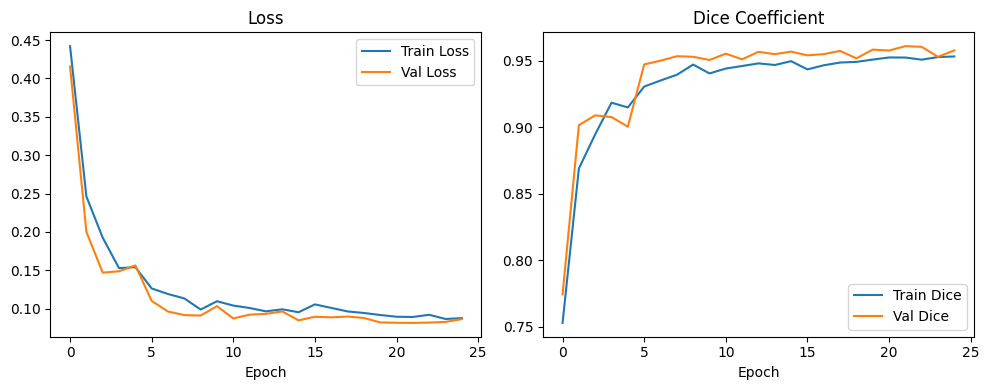

In [ ]:
# ----- Plot training curves -----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_dice"], label="Train Dice")
plt.plot(history["val_dice"],   label="Val Dice")
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## **🧪 Final Model Evaluation on Test Set**  

Now that training is complete, we **load the best model checkpoint** (the one with the highest validation Dice score during training).  

We then evaluate it on the **unseen test set** to measure its true generalization ability.  

The following metrics are reported:  
- **Loss** → Final combined loss value.  
- **Dice Coefficient** → How well the predicted masks overlap with ground truth masks.  
- **IoU (Intersection over Union)** → Measures overlap between predicted and actual regions.  
- **Pixel Accuracy** → Percentage of correctly classified pixels.  

This step ensures we get an unbiased estimate of the segmentation performance.  


In [ ]:
# Load best weights (based on validation Dice)
best_ckpt = "best_unet.pth"
assert os.path.isfile(best_ckpt), "Best checkpoint not found. Train above first."

model = UNet(in_ch=1, out_ch=1).to(DEVICE)
model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))
model.eval()

test_loss, test_dice, test_iou, test_acc = eval_model(model, test_loader)
print(f"[TEST] loss={test_loss:.4f} | dice={test_dice:.4f} | iou={test_iou:.4f} | acc={test_acc:.4f}")


[TEST] loss=0.0751 | dice=0.9640 | iou=0.9311 | acc=0.9816


## **🔮 Prediction Function**

We define a helper function `predict_mask` that:
- Takes a single preprocessed image tensor as input.  
- Adds a batch dimension before passing it through the trained U-Net model.  
- Applies a sigmoid activation to get probabilities.  
- Thresholds the probability map at 0.5 to obtain a binary segmentation mask.  


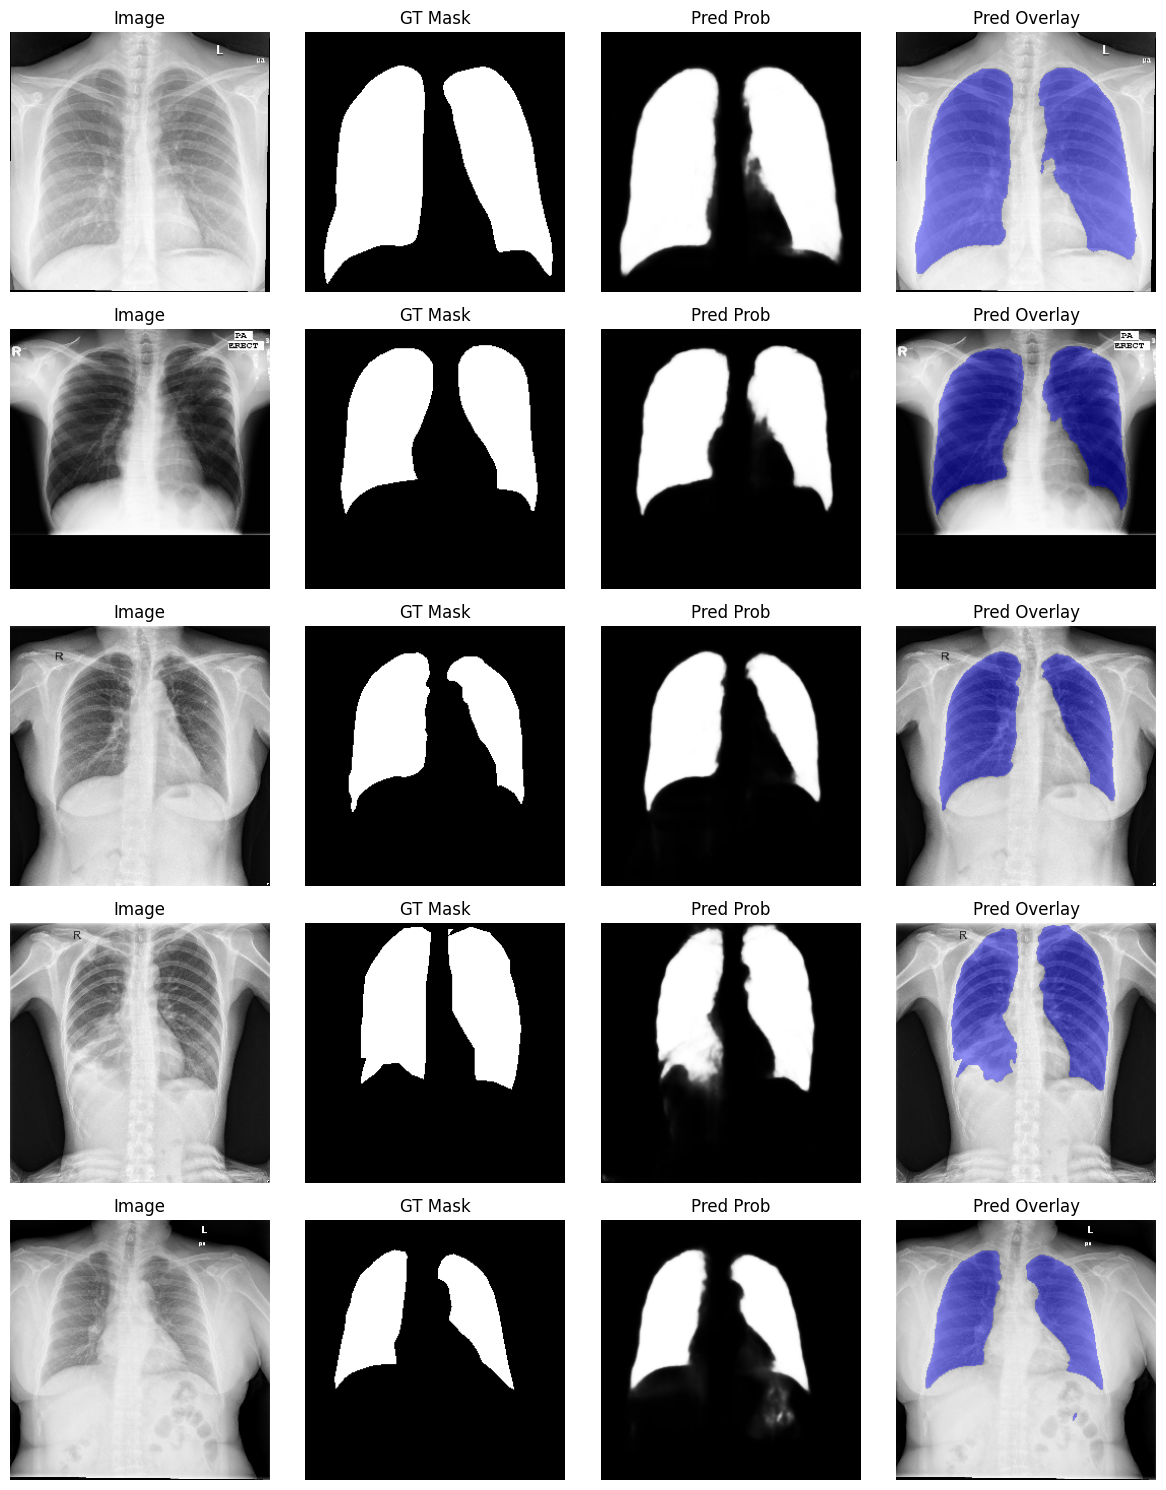

In [ ]:
@torch.no_grad()
def predict_mask(img_t):
    # img_t: tensor [1,H,W] normalized. Add batch, forward, sigmoid->bin
    x = img_t.unsqueeze(0).to(DEVICE)  # [1,1,H,W]
    logits = model(x)
    prob = torch.sigmoid(logits)[0,0]   # [H,W]
    pred = (prob > 0.5).float().cpu().numpy()
    return prob.cpu().numpy(), pred

def show_test_predictions(ds, n=5):
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    fig, axes = plt.subplots(len(idxs), 4, figsize=(12, 3*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        img_t, mask_t = ds[idx]
        prob, pred = predict_mask(img_t)

        img  = denorm_img(img_t[0]).cpu().numpy()
        true = mask_t[0].cpu().numpy()

        axes[row, 0].imshow(img, cmap="gray")
        axes[row, 0].set_title("Image")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(true, cmap="gray")
        axes[row, 1].set_title("GT Mask")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(prob, cmap="gray")
        axes[row, 2].set_title("Pred Prob")
        axes[row, 2].axis("off")

        axes[row, 3].imshow(img, cmap="gray")
        axes[row, 3].imshow(np.ma.masked_where(pred == 0, pred), alpha=0.4, cmap="winter")
        axes[row, 3].set_title("Pred Overlay")
        axes[row, 3].axis("off")

    plt.tight_layout()
    plt.show()

show_test_predictions(test_ds, n=5)


## **📏 Extra Evaluation Metrics**

While Dice, IoU, and Pixel Accuracy are standard, they may not capture all aspects of segmentation quality.  
Here we introduce **additional metrics** for deeper analysis:  

- **Precision** → Fraction of predicted positives that are correct.  
- **Recall (Sensitivity)** → Fraction of actual positives detected by the model.  
- **Specificity** → Ability to correctly classify negatives.  
- **HD95 (95th percentile Hausdorff Distance)** → Measures boundary mismatch, robust to outliers.  
- **ASSD (Average Symmetric Surface Distance)** → Average distance between predicted and ground-truth surfaces.  


In [ ]:
# ========= Extra Test Metrics: Recall, Precision, Specificity, HD95, ASSD =========
import numpy as np
from scipy import ndimage
import torch

@torch.no_grad()
def binarize_logits(logits, thr=0.5):
    """Sigmoid + threshold -> {0,1} float tensor."""
    probs = torch.sigmoid(logits)
    return (probs > thr).float()

def _safe_div(n, d, eps=1e-7):
    return (n + eps) / (d + eps)

@torch.no_grad()
def batch_precision_recall_specificity(logits, targets, thr=0.5):
    """
    Computes per-batch (aggregated over pixels) Precision, Recall (Sensitivity), and Specificity.
    logits: [N,1,H,W], targets: [N,1,H,W] in {0,1}
    Returns: precision, recall, specificity (Python floats)
    """
    preds = binarize_logits(logits, thr=thr)
    t = targets.float()

    TP = (preds * t).sum().item()
    TN = ((1 - preds) * (1 - t)).sum().item()
    FP = (preds * (1 - t)).sum().item()
    FN = ((1 - preds) * t).sum().item()

    precision  = _safe_div(TP, TP + FP)
    recall     = _safe_div(TP, TP + FN)   # sensitivity
    specificity= _safe_div(TN, TN + FP)

    return float(precision), float(recall), float(specificity)

# ---- Surface-distance helpers for HD95 / ASSD ----
def _binary_boundary(mask: np.ndarray):
    """Return boundary mask from a binary mask (2D)."""
    mask = mask.astype(bool)
    if not mask.any():
        return mask
    conn = ndimage.generate_binary_structure(2, 1)
    eroded = ndimage.binary_erosion(mask, structure=conn, border_value=0)
    return mask ^ eroded  # XOR -> boundary

def _surface_distances(a: np.ndarray, b: np.ndarray, spacing=(1.0, 1.0)):
    """
    Symmetric surface distances between boundaries of two binary masks (2D).
    Returns concatenated distances from A->B and B->A (in pixel units unless spacing provided).
    """
    a = a.astype(bool)
    b = b.astype(bool)

    a_b = _binary_boundary(a)
    b_b = _binary_boundary(b)

    # If both surfaces are empty, return empty distances (perfectly empty match).
    if not a_b.any() and not b_b.any():
        return np.array([], dtype=np.float32)

    # Distance maps to the nearest boundary pixel in the other mask.
    # SciPy's edt returns distance to the nearest 0, so we invert boundary masks.
    dist_to_b = ndimage.distance_transform_edt(~b_b, sampling=spacing)
    dists_a2b = dist_to_b[a_b]

    dist_to_a = ndimage.distance_transform_edt(~a_b, sampling=spacing)
    dists_b2a = dist_to_a[b_b]

    return np.hstack([dists_a2b, dists_b2a]).astype(np.float32)

def hd95_assd_from_arrays(pred: np.ndarray, gt: np.ndarray, spacing=(1.0, 1.0)):
    """
    pred, gt: binary arrays (H,W) in {0,1}
    Returns: hd95, assd (floats). If undefined (only one is empty), returns (np.inf, np.inf).
    """
    pred = (pred > 0).astype(np.uint8)
    gt   = (gt   > 0).astype(np.uint8)

    # Both empty -> perfect match
    if pred.sum() == 0 and gt.sum() == 0:
        return 0.0, 0.0

    # One empty, one non-empty -> undefined surface distance (set to inf)
    if (pred.sum() == 0) != (gt.sum() == 0):
        return float("inf"), float("inf")

    dists = _surface_distances(pred, gt, spacing=spacing)
    if dists.size == 0:
        return 0.0, 0.0
    hd95 = float(np.percentile(dists, 95))
    assd = float(dists.mean())
    return hd95, assd

@torch.no_grad()
def evaluate_extra_metrics(model, loader, device="cuda", thr=0.5, spacing=(1.0, 1.0), max_batches=None):
    """
    Runs through the loader and computes mean Precision, Recall, Specificity, HD95, ASSD.
    spacing: pixel spacing (dy, dx). Keep (1,1) if unknown.
    max_batches: limit for a quick pass (None = full).
    """
    model.eval()
    precs, recs, specs, hd95s, assds = [], [], [], [], []

    for bi, (imgs, masks) in enumerate(loader):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        # PRS (over all pixels in the batch)
        p, r, s = batch_precision_recall_specificity(logits, masks, thr=thr)
        precs.append(p); recs.append(r); specs.append(s)

        # HD95/ASSD: compute per-sample on CPU numpy
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > thr).astype(np.uint8)
        gts   = masks.cpu().numpy().astype(np.uint8)

        # Loop per item to get surface distances
        for i in range(preds.shape[0]):
            pred_i = preds[i, 0]  # [H,W]
            gt_i   = gts[i, 0]    # [H,W]
            hd, asd = hd95_assd_from_arrays(pred_i, gt_i, spacing=spacing)
            hd95s.append(hd); assds.append(asd)

        if (max_batches is not None) and (bi + 1 >= max_batches):
            break

    results = {
        "precision": float(np.nanmean(precs)) if len(precs) else np.nan,
        "recall":    float(np.nanmean(recs))  if len(recs)  else np.nan,
        "specificity": float(np.nanmean(specs)) if len(specs) else np.nan,
        "hd95":      float(np.nanmean(hd95s)) if len(hd95s) else np.nan,
        "assd":      float(np.nanmean(assds)) if len(assds) else np.nan,
    }
    return results

# ---- Run on your test set (after loading best_unet.pth) ----
extra = evaluate_extra_metrics(model, test_loader, device=DEVICE, thr=0.5, spacing=(1.0, 1.0))
print("Extra Test Metrics:")
for k, v in extra.items():
    print(f"  {k:12s}: {v:.4f}")


Extra Test Metrics:
  precision   : 0.9607
  recall      : 0.9675
  specificity : 0.9864
  hd95        : 5.0701
  assd        : 1.4441
